## Converting image to frequency domain

**Aim:** Approximating given image of circle

**Strategy:**
- Contour detection 
- Apply Fourier Transform and extract Fourier Descriptors
- Plot reconstructed image from Fourier Descriptors

### Initializing

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

original_center = 0.0
original_radius = 0.0
approx_center   = 0.0
approx_radius   = 0.0

scale_factor    = 0.0
shift           = 0.0

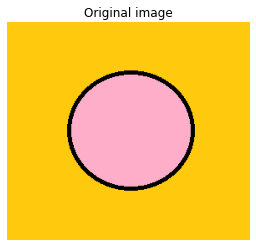

In [2]:
#Load and convert image to grayscale
img = cv2.imread('circle.png')
assert img is not None, "Image path not loaded correctly"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #CV uses BGR instead of RGB

plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.show()

In [3]:
# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Thresholding
threshold_value = 128  #Threshold chosen as midway between 0 and 255
_, binary_image = cv2.threshold(img_gray, threshold_value, 255, cv2.THRESH_BINARY)

### Extracting coordiantes

In [4]:
# Find contours
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if (len(contours) == 0):
    print("No contours in the image")

contour = contours[0]  # Only 1 contour in case of circle.png
# Convert contour to a complex representation
cntr_complex = contour[:, 0, 0] + 1j * contour[:, 0, 1]

print(f"Complex coordiantes: {cntr_complex}")

Complex coordiantes: [0.+0.j 0.+1.j 0.+2.j ... 3.+0.j 2.+0.j 1.+0.j]


### Fourier Transform on coordiantes

In [5]:
# Apply Fourier Transform on contour
fourier_descriptors = np.fft.fft(cntr_complex) #conversion from space to frequency domain

# Remove DC component for translation invariance
fourier_descriptors[0] = 0

num_descriptors = 50 # Adjust for level of detail
# Lower frequencies describe the overall shape, while higher frequencies capture details (and noise).

# Higher frequencies filtered
fourier_subset = np.zeros_like(fourier_descriptors)
fourier_subset[:num_descriptors] = fourier_descriptors[:num_descriptors]

### Inverse Transform

In [6]:
# Apply IFFT to get the approximated contour back
approx_contour = np.fft.ifft(fourier_subset)
approx_contour = np.column_stack((approx_contour.real, approx_contour.imag)).astype(np.int32)

# Calculate original radius as the max distance from the center
original_center = contour[:, 0].mean(axis=0)
original_radius = np.max(np.abs(contour[:, 0] - original_center))

# Calculate approximated radius as max distance from the approximated center
approx_center = approx_contour.mean(axis=0)
approx_radius = np.max(np.abs(approx_contour - approx_center))

# Calculate the scaling factor
scale_factor = original_radius / approx_radius

print(f"Original radius: {original_radius}")
print(f"Approx radius: {approx_radius}")
print(f"Scale factor: {scale_factor}")
fourier_descriptors *= scale_factor

print(f"Approximated contour points after IFFT: {approx_contour}")

Original radius: 145.0
Approx radius: 23.0
Scale factor: 6.304347826086956
Approximated contour points after IFFT: [[-20 -13]
 [-20 -14]
 [-19 -14]
 ...
 [-22 -11]
 [-22 -12]
 [-21 -12]]


### Reconstructing image

Original center: [145. 130.]
Approx center: [0. 0.]
Approx contour: [[-20 -13]
 [-20 -14]
 [-19 -14]
 ...
 [-22 -11]
 [-22 -12]
 [-21 -12]]
Shift: [145 130]


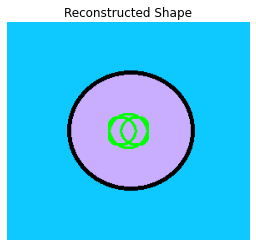

In [7]:
print(f"Original center: {original_center}")
print(f"Approx center: {approx_center}")

# Center the approximated contour by shifting it to the original center
shift = original_center - approx_center
shift = shift.astype(np.int32)

print(f"Approx contour: {approx_contour}")
print(f"Shift: {shift}")

approx_contour += shift

# Draw the reconstructed contour on a blank image
# img_color = np.zeros_like(img)  # Create a blank image
img_color = img.copy()
cv2.drawContours(img_color, [approx_contour], -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed Shape")
plt.axis("off")
plt.show()